In [1]:
from information import *
from preprocessing import *
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from snfpy.snf import snf
import snf
from sklearn.cluster import spectral_clustering
import functions as ff
from sklearn.cluster import KMeans
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import numpy as np
import matplotlib.pyplot as plt

distance = ['euclidean','minkowski','cityblock','seuclidean','sqeuclidean','cosine','correlation','hamming','jensenshannon','chebyshev','canberra','braycurtis','mahalanobis','yule','matching','dice','kulczynski1','rogerstanimoto','russellrao','sokalmichener']
no_scale = ['vha_id', 'center_name', 'cancer_type']

def extract_features(df):
    return [i for i in df if i not in no_scale]
    

In [2]:
def scaling(df):
    # Create an instance of StandardScaler
    features_to_scale = extract_features(df)
    scaler = StandardScaler()

    # Fit the scaler to the selected features
    scaler.fit(df[features_to_scale])

    # Transform the selected features using the scaler
    scaled_features = scaler.transform(df[features_to_scale])

    # Create a new dataframe with the scaled features
    df_scaled = pd.DataFrame(scaled_features, columns=features_to_scale)

    # Add the unscaled features to the new dataframe
    df_scaled[no_scale] = df[no_scale]
    return df_scaled

In [3]:
#handling numerical using standard scaler
df2 = pd.read_csv('data/Prostate/numerical.csv', index_col=0)

df2 = df2.fillna(0)

scaled_prostate = scaling(df2)

In [4]:
#Dropping columns with missed values of more than 80%

def dropping_cols(df, p=80):
    # count the number of NaN values in each column
    nan_counts = df.isna().sum()    
    # calculate the percentage of NaN values in each column
    nan_percentages = nan_counts / len(df) * 100 
    # get the list of columns to drop
    cols_to_drop = nan_percentages[nan_percentages > p].index.tolist()
    # drop the columns with more than 80% NaN values
    df = df.drop(cols_to_drop, axis=1)
    return df    

print('scaled prostate shape is ', scaled_prostate.shape)
scaled_prostate = dropping_cols(scaled_prostate)

print('scaled prostate shape is ', scaled_prostate.shape)

scaled prostate shape is  (765, 39)
scaled prostate shape is  (765, 39)


In [5]:
def histo(data, disease):
    T = data['Days']
    E = data['state']


    plt.xlabel('Days')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Days-cluster for {disease} Patients')
    plt.hist(T, bins = 30)
    plt.show()

    kmf = KaplanMeierFitter()
    kmf.fit(durations = T, event_observed = E)
    kmf.plot()

    kmf.plot_cumulative_density()

    kmf.median_survival_time_

    from lifelines.utils import median_survival_times

    median_ = kmf.median_survival_time_
    median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
    print(median_)
    print(median_confidence_interval_)

In [6]:
def groups_details(groups):
    for i in range(len(groups)):
        print(f'Number of patients in cluser {i} = {len(groups[i])}')


    Ts = [groups[i]['Days'] for i in range(len(groups))]
    Es = [groups[i]['state'] for i in range(len(groups))]

    kmf = KaplanMeierFitter()
    for i in range(len(groups)):
        kmf.fit(durations = Ts[i], event_observed = Es[i], label=f'Cluster {i}')
        kmf.plot()

    #kmf.plot_cumulative_density()

    kmf.median_survival_time_

    from lifelines.utils import median_survival_times

    median_ = kmf.median_survival_time_
    median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
    print(median_)
    print(median_confidence_interval_)

    import itertools

    # Generate all combinations of length 2 from a list of integers
    numbers = [i for i in range(len(groups))]
    combinations = itertools.combinations(numbers, 2)

    # Perform the log-rank test
    for i, j in combinations:
        results = logrank_test(groups[i]['Days'], groups[j]['Days'], event_observed_A=groups[i]['state'], event_observed_B=groups[j]['state'])
        print(f'P-value ({i},{j}) = ', results.p_value)

In [7]:
#dropping rows with missed values of more than 80%

print('scaled prostate shape is ', scaled_prostate.shape)
scaled_prostate.dropna(thresh=len(scaled_prostate.columns) * 0.2)
print('scaled prostate shape is ', scaled_prostate.shape)

scaled prostate shape is  (765, 39)
scaled prostate shape is  (765, 39)


In [8]:
#dropping duplicate
scaled_prostate = scaled_prostate.drop_duplicates()
print('scaled prostate shape is ', scaled_prostate.shape)

#removing correlated features with more than 0.9 correlation
scaled_prostate = remove_correlated(scaled_prostate)
print('scaled prostate shape is ', scaled_prostate.shape)

scaled prostate shape is  (765, 39)
scaled prostate shape is  (765, 27)


In [9]:
#Working on Categorical dataframes
c_prostate = pd.read_csv('data/Prostate/categorical data.csv', index_col=0)

Prostate_patients = list(c_prostate['vha_id'])

scaled_prostate = scaled_prostate[extract_features(scaled_prostate)]

Prostate_DB = [scaled_prostate]

scaled_prostate

,Rectum_V75Gy,LargeBowel_D0_035cc,Bladder - Bladder_Subtraction_Structure (Bladder - Bladder_Subtraction_Structure)_V65Gy,Bladder_Already_Subtracted_V40Gy,AcuteGUTotal,SmallBowel_V45Gy,PTV_D2%,LateGUWithGrade,TotalNumberOfNotes,LateGUTotal,...,SmallBowel_D0.035cc,Rectum_V40Gy,Femur_R_V50Gy,LateGIWithGrade,PTV_V100% Rx1,Rectum_V50Gy,AcuteGIWithGrade,center_id,AcuteGUWithGrade,AcuteGITotal
0,0.707025,-0.723051,-0.305939,-0.261041,3.968866,-0.190111,0.272649,-0.133829,0.231610,-0.694439,...,-0.530060,-0.414484,0.304984,-0.091851,0.500763,0.629903,1.577301,-1.568786,4.175981,0.523641
1,0.666237,1.505755,-0.305939,-0.261041,2.176727,-0.190111,-0.483621,-0.133829,-0.634805,-0.694439,...,-0.530060,-0.414484,0.075204,-0.091851,0.296825,0.211193,-0.257886,-1.568786,1.642976,-0.619256
2,0.892620,-0.723051,-0.305939,-0.261041,3.072796,-0.190111,-0.963609,-0.133829,-0.634805,-0.694439,...,-0.530060,-0.414484,0.770178,-0.091851,-0.413257,0.280887,-0.257886,-1.568786,2.656178,-0.619256
3,1.608283,-0.723051,-0.305939,-0.261041,4.267555,-0.190111,0.079457,-0.133829,0.664818,0.133047,...,-0.530060,-0.414484,1.831176,-0.091851,0.427355,1.233848,5.247675,-1.568786,3.669380,3.380886
4,1.289310,-0.723051,-0.305939,-0.261041,3.670176,-0.190111,0.574796,-0.133829,0.231610,-0.694439,...,-0.530060,-0.414484,0.083315,-0.091851,0.500215,0.888332,-0.257886,-1.568786,4.175981,-0.619256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,0.353186,1.911916,-0.305939,-0.261041,-0.212792,1.433387,0.795970,-0.133829,-0.201597,-0.694439,...,2.366442,-0.414484,-0.292376,-0.091851,0.260008,0.682869,-0.257886,1.625993,-0.383427,2.809437
761,-0.197051,1.340859,-0.305939,-0.261041,1.579347,0.438665,0.504585,-0.133829,1.098025,-0.694439,...,2.156181,-0.414484,-0.289305,-0.091851,0.467170,0.743614,-0.257886,1.625993,-0.383427,2.809437
762,-0.427615,0.715340,-0.305939,-0.261041,0.683277,-0.190111,-0.260604,-0.133829,0.664818,-0.694439,...,-0.190649,-0.414484,-0.292376,-0.091851,0.085603,1.383795,-0.257886,1.625993,-0.383427,-0.047807
763,-1.111080,-0.543118,0.444433,-0.261041,-0.511482,-0.190111,-0.437571,-0.133829,-1.068012,-0.694439,...,-0.394500,2.314605,-0.292376,-0.091851,0.204325,-1.480970,-0.257886,1.625993,-0.383427,-0.047807


# Features --> PSG --> SNF and check clustering of the SNF...

# 1- Prostate:

In [10]:
from scipy.spatial.distance import pdist, squareform


dist = distance[0]
prostate_db = []
# scaled_prostate[i] for i in scaled_prostate]

# Calculate the similarity matrix
for d in scaled_prostate:
    distances = pdist(scaled_prostate[d].to_numpy().reshape(-1, 1), metric='euclidean')
    similarity_matrix = 1 / (1 + squareform(distances))
    prostate_db.append(similarity_matrix)


affinity_networks = snf.make_affinity(prostate_db, metric=dist, K=20, mu=0.5)
fused_network = snf.snf(affinity_networks, K=20)
best, second = snf.get_n_clusters(fused_network)

print(best, second)


2 3


In [11]:
# Clustering

Prostate_labels = spectral_clustering(fused_network, n_clusters=best)
Prostate_All     = {'vha_id': Prostate_patients    , 'cluster': list(Prostate_labels) }
df_prostate = pd.DataFrame(Prostate_All)

survival0 = pd.read_csv('data/survival.csv')
Prostate_survival = pd.merge(df_prostate, survival0, on='vha_id')

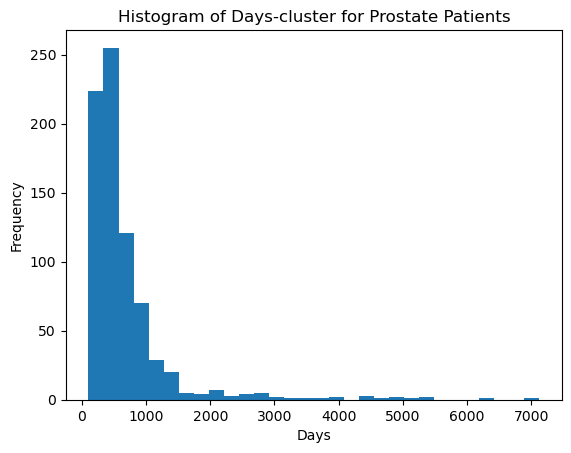

inf
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                     inf                     inf


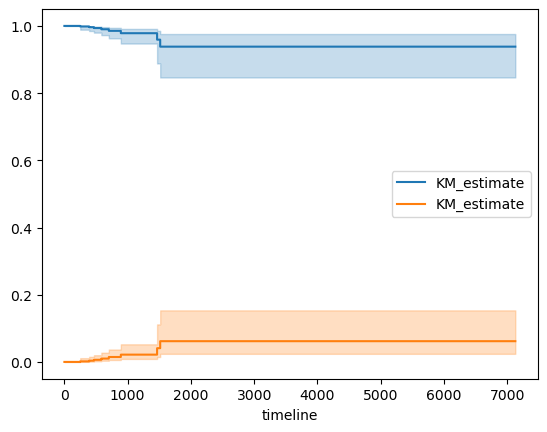

In [12]:
histo(Prostate_survival, 'Prostate')

Number of patients in cluser 0 = 605
Number of patients in cluser 1 = 160
inf
     Cluster 1_lower_0.95  Cluster 1_upper_0.95
0.5                   inf                   inf
P-value (0,1) =  0.0017861619655288458


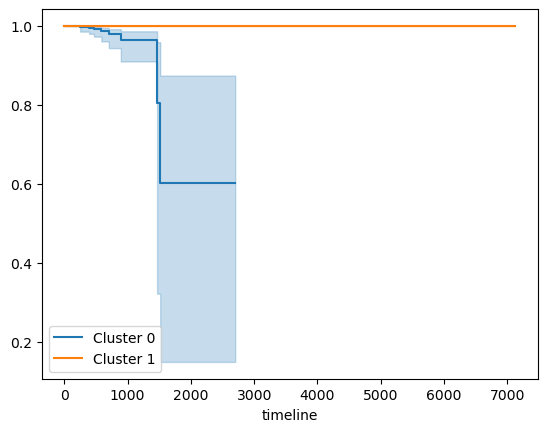

In [13]:
groups = dict(tuple(Prostate_survival.groupby('cluster')))

groups_details(groups)


# Lung

In [14]:
# Preprocessing
n_lung = pd.read_csv('data/Lung/numerical.csv', index_col=0).fillna(0)
c_lung = pd.read_csv('data/Lung/categorical.csv', index_col=0)

scaled_lung = scaling(n_lung)
print('scaled lung shape is ', scaled_lung.shape)
scaled_lung = dropping_cols(scaled_lung)
print('scaled lung shape is ', scaled_lung.shape)

print('scaled lung shape is ', scaled_lung.shape)
scaled_lung.dropna(thresh=len(scaled_lung.columns) * 0.2)
print('scaled lung shape is ', scaled_lung.shape)

scaled_lung = scaled_lung.drop_duplicates()
print('scaled lung shape is ', scaled_lung.shape)
scaled_lung = remove_correlated(scaled_lung)
print('scaled lung shape is ', scaled_lung.shape)


scaled lung shape is  (773, 25)
scaled lung shape is  (773, 25)
scaled lung shape is  (773, 25)
scaled lung shape is  (773, 25)
scaled lung shape is  (773, 25)
scaled lung shape is  (773, 16)


In [15]:
# c_lung = c_lung.drop(columns=['Unnamed: 0.1'])
# for f in c_lung:
#     c_lung[f] = c_lung[f].fillna(c_lung[f].mode()[0])

Lung_patients = list(c_lung['vha_id'])
Lung_cancer_type = list(c_lung['cancer_type'])
scaled_lung = scaled_lung[extract_features(scaled_lung)]

# # Calculate the similarity matrix
lung_db = []
for d in scaled_lung:
    distances = pdist(scaled_lung[d].to_numpy().reshape(-1, 1), metric='euclidean')
    similarity_matrix = 1 / (1 + squareform(distances))
    lung_db.append(similarity_matrix)


affinity_networks = snf.make_affinity(lung_db, metric=dist, K=20, mu=0.5)
fused_network = snf.snf(affinity_networks, K=20)
best, second = snf.get_n_clusters(fused_network)
print(best, second)


2 4


In [23]:
# Clustering
lung_labels = spectral_clustering(fused_network, n_clusters= 4)
lung_All     = {'vha_id': Lung_patients    , 'cluster': list(lung_labels), 'cancer_type': Lung_cancer_type }
df_lung = pd.DataFrame(lung_All)

survival0 = pd.read_csv('data/survival.csv')
Lung_survival = pd.merge(df_lung, survival0, on='vha_id')

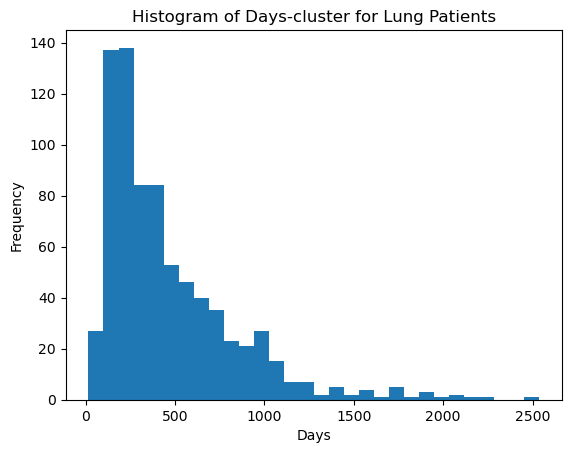

795.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   738.0                   885.0


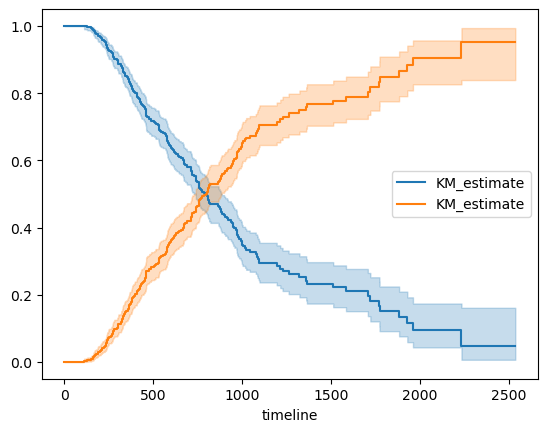

In [24]:
histo(Lung_survival, 'Lung')


Number of patients in cluser 0 = 154
Number of patients in cluser 1 = 145
Number of patients in cluser 2 = 264
Number of patients in cluser 3 = 210
716.0
     Cluster 3_lower_0.95  Cluster 3_upper_0.95
0.5                 590.0                 807.0
P-value (0,1) =  0.004299999278290931
P-value (0,2) =  6.403868432349357e-09
P-value (0,3) =  1.1929830378531405e-06
P-value (1,2) =  0.010123118543482485
P-value (1,3) =  0.20457797285508078
P-value (2,3) =  0.2778160777690924


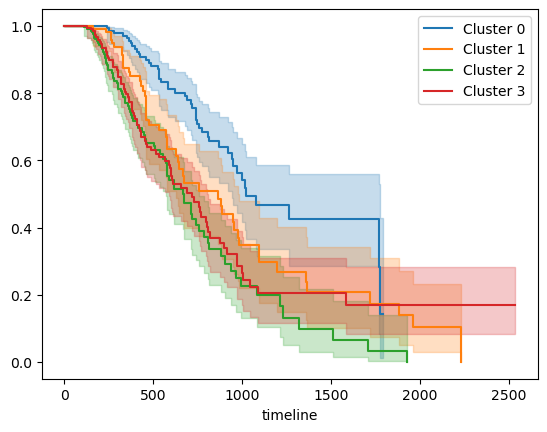

In [25]:
groups = dict(tuple(Lung_survival.groupby('cluster')))
groups_details(groups)


In [19]:
print(Lung_survival.groupby(['cluster', 'cancer_type']).agg({'vha_id': 'count'}))

                       vha_id
cluster cancer_type          
0       NSCLC             243
        NSCLC Surgery      30
        SCLC               76
1       NSCLC             200
        NSCLC Surgery      24
        SCLC               52
2       NSCLC             104
        NSCLC Surgery      11
        SCLC               33


In [20]:
# replacing the cancer_type with 0,1,2 values
# define the replacement values
replacement_dict = {'NSCLC': 0, 'SCLC': 1, 'NSCLC Surgery': 2}

# replace the feature values with the replacement values
Lung_survival['cancer_type'] = Lung_survival['cancer_type'].replace(replacement_dict)
Lung_survival

,vha_id,cluster,cancer_type,state,firstVisit,lastVisit,Days
0,506-NSCLC-01,2,0,0,11/18/2009,5/5/2010,168
1,506-NSCLC-02,1,0,0,11/10/2009,5/9/2010,180
2,506-NSCLC-03,1,0,0,12/9/2009,8/28/2010,262
3,506-NSCLC-04,1,0,0,11/18/2009,11/21/2010,368
4,506-NSCLC-05,1,0,1,12/17/2009,1/15/2011,394
...,...,...,...,...,...,...,...
768,632-NSCLC-06,0,0,1,12/9/2009,6/20/2010,193
769,667-NSCLC-08,0,0,0,11/9/2009,4/15/2010,157
770,671-NSCLC-08,0,0,0,11/22/2009,3/22/2010,120
771,671-SCLC-06,0,1,0,11/30/2009,6/3/2010,185


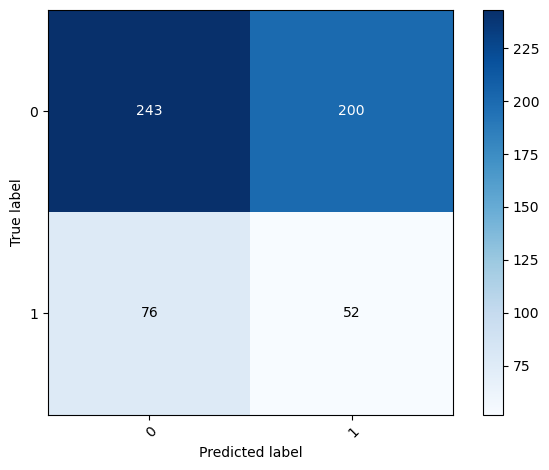

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Generate example data
y_true = Lung_survival['cancer_type']
y_pred = Lung_survival['cluster']
labels = [0, 1]

# Create the confusion matrix
matrix = confusion_matrix(y_true, y_pred, labels=labels)

# Plot the matrix
fig, ax = plt.subplots()
im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(matrix.shape[1]),
       yticks=np.arange(matrix.shape[0]),
       xticklabels=labels, yticklabels=labels,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
         
# Loop over data dimensions and create text annotations
fmt = 'd'
thresh = matrix.max() / 2.
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(j, i, format(matrix[i, j], fmt),
                ha="center", va="center",
                color="white" if matrix[i, j] > thresh else "black")

fig.tight_layout()
plt.show()
